In [1]:
!pip install numpy matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


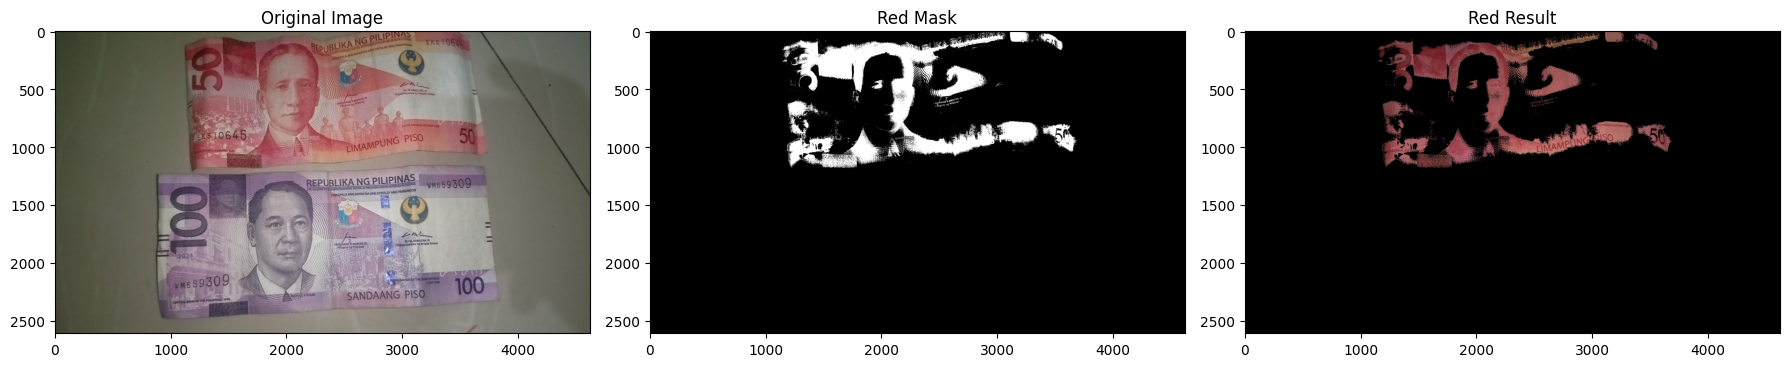

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('bills.jpg')
image = cv2.resize(image, (4624, 2608))

# Convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define a more precise red color range in HSV
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])

# The purple hue is around 140-155. Let's adjust the second red range
# to be more specific, starting closer to 170
lower_red2 = np.array([170, 100, 100])
upper_red2 = np.array([180, 255, 255])

# Create masks
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

# Combine both masks
red_mask = cv2.bitwise_or(mask1, mask2)

# Apply the mask to the original image
red_result = cv2.bitwise_and(image, image, mask=red_mask)

# Convert to RGB for display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
red_result_rgb = cv2.cvtColor(red_result, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 3, figsize=(18, 12))
axs[0].imshow(image_rgb)
axs[0].set_title('Original Image')
axs[1].imshow(red_mask, cmap='gray')
axs[1].set_title('Red Mask')
axs[2].imshow(red_result_rgb)
axs[2].set_title('Red Result')

plt.tight_layout()
plt.show()

In [23]:
import cv2
import numpy as np
import tkinter as tk
from PIL import Image, ImageTk
import os

BILL_INFO = {
    "20": {"hsv": ([15, 80, 80], [35, 255, 255]), "color": (0, 165, 255)},  
    "50": {"hsv": ([0, 150, 50], [10, 255, 255]), "color": (0, 0, 255)},    
    "100": {"hsv": ([125, 50, 50], [160, 255, 255]), "color": (255, 0, 255)}, 
    "200": {"hsv": ([35, 50, 50], [70, 255, 255]), "color": (0, 255, 0)},    
    "500": {"hsv": ([15, 80, 80], [40, 255, 255]), "color": (0, 255, 255)},  
    "1000": {"hsv": ([100, 50, 50], [130, 255, 255]), "color": (255, 0, 0)}, 
}

ASPECT_RATIO_RANGE = (1.45, 1.65)
MIN_CONTOUR_AREA = 2000
MASK_THRESHOLD = 500
MATCH_THRESHOLD = 0.6  


TEMPLATE_DIR = "templates"  
TEMPLATES = {}
for bill in BILL_INFO:
    path = os.path.join(TEMPLATE_DIR, f"{bill}.jpg")
    if os.path.exists(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        TEMPLATES[bill] = cv2.resize(img, (200, 125)) 
    else:
        print(f"Warning: Template for {bill} missing!")


def detect_bills(frame):
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    bills_count = {k:0 for k in BILL_INFO.keys()}

    for bill, info in BILL_INFO.items():
        lower = np.array(info["hsv"][0])
        upper = np.array(info["hsv"][1])
        mask = cv2.inRange(hsv_frame, lower, upper)

        if cv2.countNonZero(mask) < MASK_THRESHOLD:
            continue

    
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area < MIN_CONTOUR_AREA:
                continue

            x, y, w, h = cv2.boundingRect(cnt)
            aspect_ratio = w / float(h)
            if not (ASPECT_RATIO_RANGE[0] <= aspect_ratio <= ASPECT_RATIO_RANGE[1]):
                continue

            if bill in TEMPLATES:
                roi = cv2.cvtColor(frame[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)
                roi_resized = cv2.resize(roi, (TEMPLATES[bill].shape[1], TEMPLATES[bill].shape[0]))
                res = cv2.matchTemplate(roi_resized, TEMPLATES[bill], cv2.TM_CCOEFF_NORMED)
                if np.max(res) < MATCH_THRESHOLD:
                    continue  

            bills_count[bill] += 1
            cv2.rectangle(frame, (x, y), (x+w, y+h), info["color"], 2)
            cv2.putText(frame, f"{bill} PHP", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, info["color"], 2)

    return frame, bills_count


def update_frame():
    ret, frame = cap.read()
    if ret:
        frame, counts = detect_bills(frame)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame_rgb)
        imgtk = ImageTk.PhotoImage(image=img)
        lbl.imgtk = imgtk
        lbl.configure(image=imgtk)

        if counts:
            total = sum(int(k)*v for k,v in counts.items())
            count_text = " | ".join([f"{k}₱:{v}" for k,v in counts.items()])
            lbl_counts.config(text=f"{count_text} | Total: {total}₱")
        else:
            lbl_counts.config(text="No bills detected")

    root.after(10, update_frame)


root = tk.Tk()
root.title("Philippine Bill Detection")

lbl = tk.Label(root)
lbl.pack()

lbl_counts = tk.Label(root, text="", font=("Arial", 14))
lbl_counts.pack()

cap = cv2.VideoCapture(0)
update_frame()
root.mainloop() 